## 2.1. Load del Dataset

In [4]:
my_dir = "dataset/"

Load del file .csv con i dati della verona card

|campo  | label	| descrizione	|
|-----|-----|-------------------|
|0	| data	| data di attivazione della verona card	|
|1	| codice VC	| codice identificativo della verona card	|
|2	| strisciata	| data ed ora di utilizzo della verona card|
|3  | formato | formato della verona card (validità 24 o 72 ore)|
|4	| poi	| codice del punto di interesse in cui è stata utilizzata	|
|5	| id	| identificativo iniviato dal server per la raccolta dei dati	|


In [5]:
# load the data
input_filename = my_dir+"veronaCard.csv"
rawData = sc.textFile(input_filename)

# extract header
#header = rawData.first() 

# remove the header, separate the elements for each row
#data_vc = rawData.filter(lambda row: row != header).map(lambda row : row.split(","))
data_vc = rawData.map(lambda row : row.split(","))

# put the data in cache
data_vc.persist()

# check the output
print(data_vc.take(5), "\n")


[['2017-11-29', '0435803A9C4C81', '29/11/2017 12:07', 'vrcard2-24', '61', '1222145'], ['2017-11-29', '04CF813A9C4C80', '29/11/2017 12:07', 'vrcard2-24', '61', '1222146'], ['2017-10-05', '04B28C4A9C4C80', '05/10/2017 12:19', 'vrcard2-24', '61', '1222147'], ['2017-10-05', '04E279429C4C80', '05/10/2017 12:16', 'vrcard2-24', '61', '1222148'], ['2017-12-28', '040F9D429C4C80', '28/12/2017 11:06', 'vrcard2-24', '61', '1222149']] 



22/04/08 12:30:41 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Load del file .csv con i dati delle stazioni metereologiche

In [46]:
# load the data
input_filename = my_dir+"meteo.csv"
rawData = sc.textFile(input_filename)

# extract header
#header = rawData.first() 

# remove the header, separate the elements for each row
#data_weather = rawData.filter(lambda row: row != header).map(lambda row : row.split(",")) 
data_weather = rawData.map(lambda row : row.split(",")) 

# put the data in cache
data_weather.persist()

# check the output
print(data_weather.take(5))

[['2016-02-08', '11.54', '10.7', '82', '1015.5', '4.26', 'ESE', '10.30', '7.8', '243'], ['2016-02-08', '11.50', '9.0', '97', '1015.5', '7.97', 'SSW', '19.80', '8.5', '351'], ['2016-02-08', '11.53', '8.7', '91', '1020.4', '5.00', 'S', '10.20', '7.3', '280'], ['2016-02-08', '11.48', '8.5', '67', '1015.0', '9.45', 'SSE', '8.10', '2.7', '343'], ['2016-02-08', '11.51', '9.6', '41', '1016.3', '0.74', 'S', '4.20', '-3.0', '368']]


22/04/07 21:43:57 WARN BlockManager: Task 328 already completed, not releasing lock for rdd_215_0


### Q1 - Distribuzione visite per PoI

Per ogni Verona Card, il numero di punti di interesse (Points of Interest, PoI) visitati, da cui costruire la sua distribuzione (l'asse x contiene il numero di PoI, l'asse Y la percentuale di Verona Card usate per quel numero di PoI);


In [6]:

#per l'analisi non occorre sapere anche l'rario della strisciata della VC, estraggo solo la data
def extract_data(data_ora):
    lista = data_ora.split(' ')
    return lista[0]

#tengo solo i dati di mio interesse
d_vc = data_vc.map(lambda x: (x[1], extract_data(x[2]),x[4]))

print(d_vc.take(10))


[('0435803A9C4C81', '29/11/2017', '61'), ('04CF813A9C4C80', '29/11/2017', '61'), ('04B28C4A9C4C80', '05/10/2017', '61'), ('04E279429C4C80', '05/10/2017', '61'), ('040F9D429C4C80', '28/12/2017', '61'), ('049EC64A9C4C80', '19/11/2017', '61'), ('0489CF4A9C4C80', '19/11/2017', '61'), ('04C5653A9C4C80', '05/10/2017', '61'), ('045F673A9C4C80', '05/10/2017', '61'), ('04E6C5429C4C80', '05/10/2017', '61')]


22/04/08 12:30:48 WARN BlockManager: Task 1 already completed, not releasing lock for rdd_2_0


In [7]:
#togliere id non validi e prendo i dati di interesse
poiVisited = data_vc.filter(lambda x: len(x[1]) > 5)\
                .map(lambda x: ((x[1],x[0]), 1))\
                .reduceByKey(lambda a,b: a+b)\
                .sortBy(lambda x: x[1],ascending = False)

poiVisited.take(10)

[(('0444283A9C4C80', '2017-07-27'), 14),
 (('041F44F2185081', '2019-06-14'), 13),
 (('04BCA8F2185080', '2019-08-20'), 13),
 (('0447B04A3F3880', '2014-03-30'), 13),
 (('043C01F2185085', '2019-06-27'), 13),
 (('04800FBA7B3F84', '2016-08-10'), 13),
 (('04235EE2185080', '2018-11-21'), 13),
 (('049061E2185080', '2019-01-05'), 13),
 (('040F6E8ABF3180', '2014-02-28'), 13),
 (('042383E2185080', '2018-11-21'), 13)]

In [8]:
totalVc = poiVisited.count()  #482815
print(totalVc)

countSamePoiVisited = poiVisited.map(lambda x: (x[1],1))\
                                .reduceByKey(lambda a,b: a+b)\
                                .sortByKey()
countVisit = countSamePoiVisited.collect()
print(countVisit)

671032
[(1, 91865), (2, 120970), (3, 139764), (4, 128039), (5, 93356), (6, 55028), (7, 26394), (8, 10686), (9, 3603), (10, 1000), (11, 253), (12, 62), (13, 11), (14, 1)]


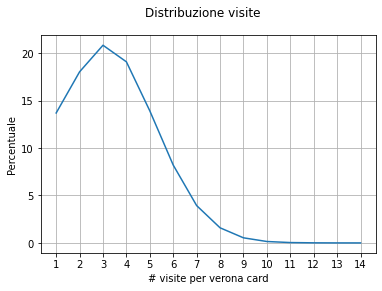

In [9]:
import matplotlib.pyplot as plt

percVc = [ x[1] / totalVc * 100 for x in countVisit]

x_indexes = list(range(0,len(countVisit)))
x_labels = [x[0] for x in countVisit]

plt.xticks(x_indexes, x_labels)

plt.suptitle('Distribuzione visite')
plt.xlabel('# visite per verona card')
plt.ylabel('Percentuale')

plt.grid()
plt.plot(percVc)
plt.show()

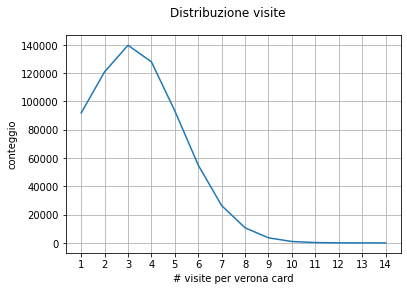

In [10]:
percVc = [ x[1] for x in countVisit]

x_indexes = list(range(0,len(countVisit)))
x_labels = [x[0] for x in countVisit]

plt.xticks(x_indexes, x_labels)

plt.suptitle('Distribuzione visite')
plt.xlabel('# visite per verona card')
plt.ylabel('conteggio')

plt.grid()
plt.plot(percVc)
plt.show()

### Q2 - Distribuzione visite giornaliere

Per ogni PoI, la distribuzione del numero di visite giornaliere (l'asse x indica il range di visitatori, l'asse y la percentuali di giorni che quel PoI ha ricevuto un numero di visitatori all'interno di quel range);

In [11]:
def extract_data(data_ora):
    lista = data_ora.split(' ')
    return lista[0]

count_daily_visit = data_vc.filter(lambda x: len(x[1]) > 5)\
                .map(lambda x: ((x[4],extract_data(x[2])), 1))\
                .reduceByKey(lambda a,b: a+b)\
                .sortBy(lambda x: x[1],ascending = False)

count_daily_visit.take(10)

[(('49', '29/04/2018'), 836),
 (('49', '26/04/2014'), 825),
 (('49', '01/11/2019'), 820),
 (('49', '02/05/2015'), 754),
 (('49', '30/10/2016'), 728),
 (('49', '13/02/2016'), 712),
 (('49', '03/06/2017'), 711),
 (('49', '23/04/2017'), 707),
 (('49', '26/04/2019'), 701),
 (('49', '24/04/2016'), 696)]

In [12]:
poi_list = data_vc.map(lambda x: x[4]).distinct().collect()
print(poi_list)

['61', '76', '42', '200', '63', '202', '59', '52', '58', '62', '71', '201', '54', '75', '49']


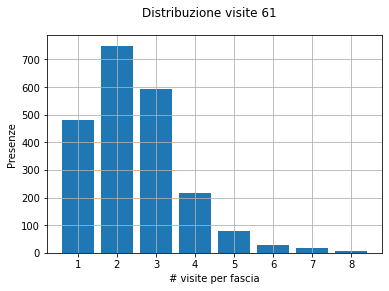

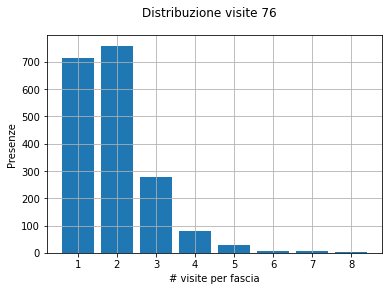

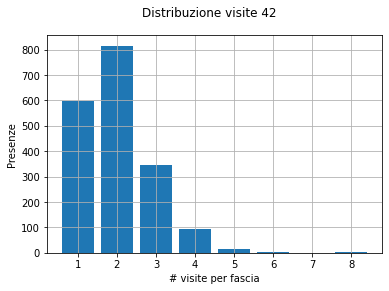

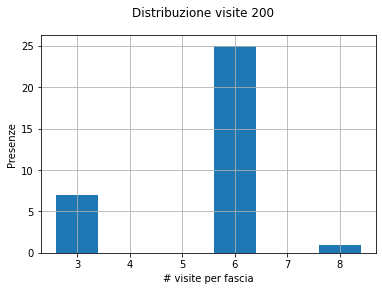

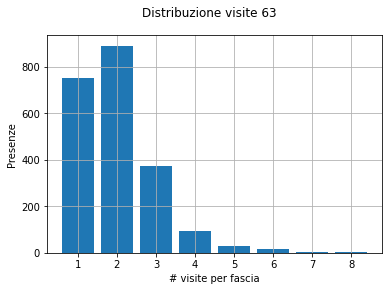

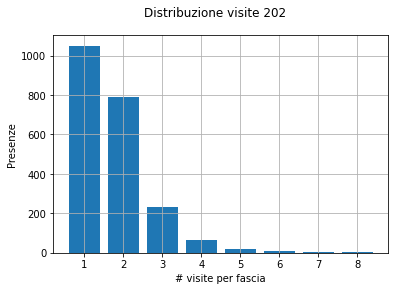

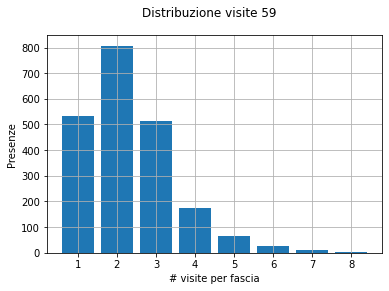

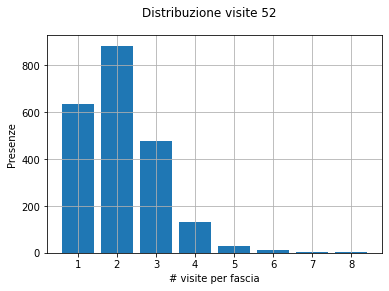

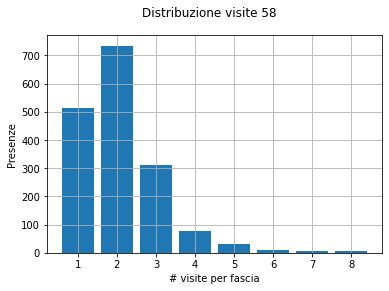

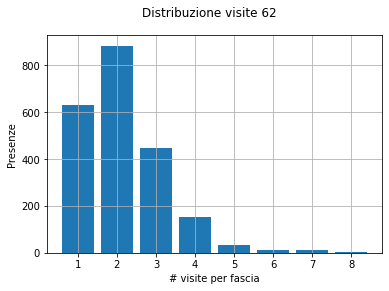

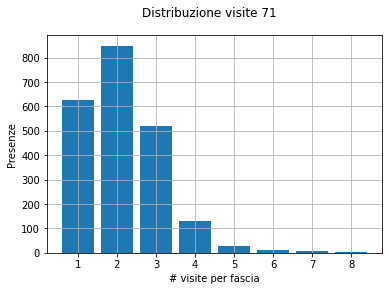

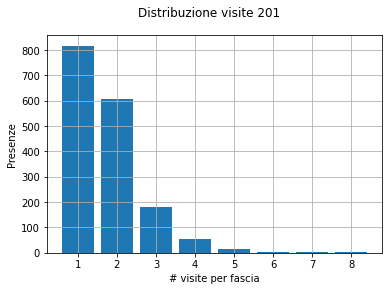

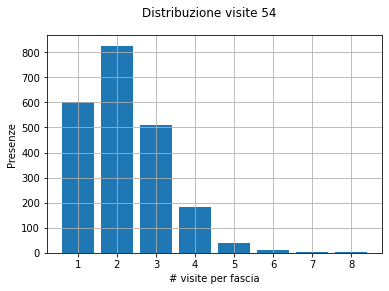

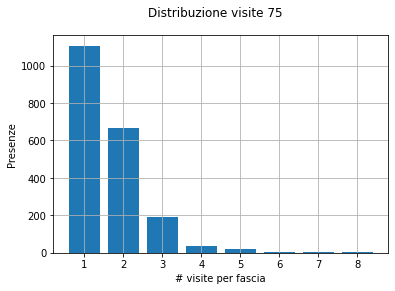

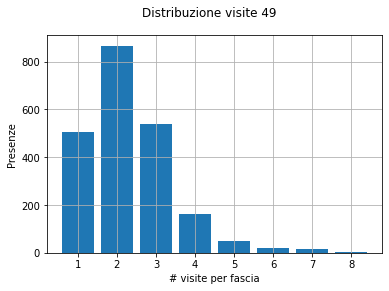

In [58]:
n_fasce = 8

def get_fascia(presenza, max_p):
    if max_p == presenza:
        return n_fasce
    fascia = max_p/n_fasce
    return int(presenza/fascia) + 1

for poi in poi_list:
    count_per_poi = count_daily_visit.filter(lambda x: x[0][0] == poi)\
                                    .map(lambda x: (x[0][1],int(x[1]))) #.map(lambda x: int(x[1]))
    
    #print(count_per_poi.take(10))
    list_presenze = count_per_poi.map(lambda x : x[1])
    max_pres = list_presenze.takeOrdered(1, key=lambda x : -x)
    
    
    count_visit = count_per_poi.map(lambda x: (get_fascia(x[1],max_pres[0]), 1))\
                                .reduceByKey(lambda a,b: a+b)\
                                .sortByKey()\
                                .collect()
    

    #print(count_visit)
    presenze = [ x[1] for x in count_visit]
    fascia = [ x[0] for x in count_visit]
    
    x_labels = [x[0]+1 for x in count_visit]

    plt.suptitle('Distribuzione visite {}'.format(poi))
    plt.xlabel('# visite per fascia')
    plt.ylabel('Presenze')
    plt.grid()
    plt.bar(fascia,presenze)
    plt.show()
    
    
                    

## Dati metereologici

#### C1

giorni in cui ha piovuto per almeno X ore / giorni in cui ha piovuto meno di X ore;

#### C2

giorni in cui la temperatura media era superiore a Y / giorni in cui era inferiore a Y;

Ricalcola Q1 e Q2 considerando la suddivisione in C1 (per alcuni valori di X scelti da te) e confronta le distribuzioni nei giorni in cui ha piovuto / non ha piovuto per X ore.

Ricalcola Q1 e Q2 considerando la suddivisione in C2 (per alcuni valori di Y scelti da te) e confronta le distribuzioni nei giorni in cui la temperatura era maggiore / minore di Y.

# Punto bonus

Aggiungo anche il seguente punto, ma mi rendo conto che potrebbe essere un carico eccessivo per il progetto, per cui considerala come domanda "bonus", non necessaria.
Se assumiamo che in uno specifico giorno i dati delle centraline non siano stati registrati, è possibile risalire all'informazione se in tale giorno ha piovuto / non ha piovuto o ad una stima della temperatura media guardando la distribuzione dell'occupazione dei PoI o guardando l'uso delle Verona Card?